# Дворы и квартиры

## Создание обучающей выборки

Импортируем библиотеки

In [1]:
import os

from PIL import Image

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

Прописываем путь к данным

In [2]:
path_in = 'data/train/indoor/'
path_out = 'data/train/outdoor/'

Определяем функцию для загрузки изображения

In [3]:
def image_load(path):
    image = Image.open(path) 
    width  = image.size[0] 
    height = image.size[1] 
    pix = image.load() 
    return np.array([[pix[i, j] for i in range(width)] for j in range(height)])

In [4]:
image = image_load(path_in + '3.jpg')

Привём пошагово расчёт гистограмм для каждого цвета

In [5]:
red = image[:, :, 0]
green = image[:, :, 1]
blue = image[:, :, 2]

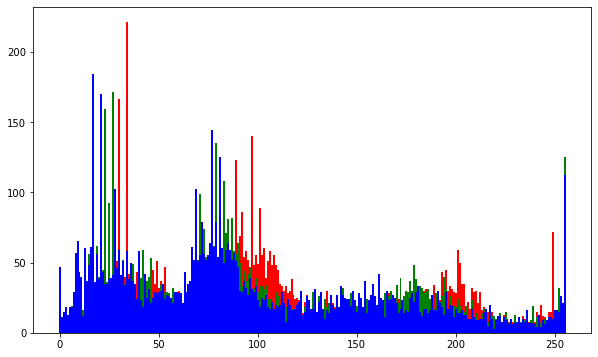

In [6]:
plt.figure(figsize=(10, 6))
red_frequency, intervals, im = plt.hist(red.flatten(), 256, (-0.5, 255.5), color='red')
green_frequency, intervals, im = plt.hist(green.flatten(), 256, (-0.5, 255.5), color='green')
blue_frequency, intervals, im = plt.hist(blue.flatten(), 256, (-0.5, 255.5), color='blue')

Теперь записываем частоты в один вектор

In [7]:
x = np.hstack((red_frequency, green_frequency, blue_frequency))
x.shape

(768,)

Определим функцию

In [8]:
def color_hist(image):
    '''
    На вход – результат функции image_load
    на выход: вектор размерности 768 = 256 + 256 + 256,
    который последовательно содержит частоты красного, 
    зелёного и синего цветов'''
    red = image[:, :, 0]
    green = image[:, :, 1]
    blue = image[:, :, 2]
    red_frequency, intervals = np.histogram(red.flatten(), 256, (-0.5, 255.5))
    green_frequency, intervals = np.histogram(green.flatten(), 256, (-0.5, 255.5))
    blue_frequency, intervals = np.histogram(blue.flatten(), 256, (-0.5, 255.5))
    return np.hstack((red_frequency, green_frequency, blue_frequency))

Время создать обучающую выборку! 

In [9]:
cols = ['red_'   + str(i) for i in range(256)] + \
       ['green_' + str(i) for i in range(256)] + \
       ['blue_'  + str(i) for i in range(256)] + ['indoor']

In [10]:
data = pd.DataFrame(columns=cols)
data.head()

,red_0,red_1,red_2,red_3,red_4,red_5,red_6,red_7,red_8,red_9,...,blue_247,blue_248,blue_249,blue_250,blue_251,blue_252,blue_253,blue_254,blue_255,indoor


In [11]:
# for file in tqdm(os.listdir(path_in)):
#     data.loc[int(file[:-4])] = np.append(color_hist(image_load(path_in + file)), 1)

In [12]:
# for file in tqdm(os.listdir(path_out)):
#     data.loc[int(file[:-4])] = np.append(color_hist(image_load(path_out + file)), 0)

In [13]:
# data = data.sort_index()
# data.head()

In [14]:
# data.to_csv('data/train/images_hists.csv')

In [15]:
# import multiprocessing as mp
# mp.cpu_count()

## Обучение логистической регрессии

Импортируем логистическую регрессию из `sklearn`

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split

Импортируем данные

In [17]:
data = pd.read_csv('data/train/images_hists.csv', index_col=0)
data.head()

,red_0,red_1,red_2,red_3,red_4,red_5,red_6,red_7,red_8,red_9,...,blue_247,blue_248,blue_249,blue_250,blue_251,blue_252,blue_253,blue_254,blue_255,indoor
1,15,2,5,3,2,2,3,5,0,5,...,6,12,6,7,11,3,4,12,54,0
2,0,0,0,0,0,0,0,0,0,0,...,2,3,0,0,0,0,0,0,0,0
3,18,2,2,10,5,11,19,8,46,42,...,11,11,10,16,16,15,26,21,112,1
5,2,0,2,0,1,0,1,0,0,2,...,67,45,169,42,73,34,129,29,235,0
6,11,1,3,1,2,2,2,2,2,3,...,18,15,23,12,17,20,24,16,182,0


Разбиваем исходные данные на матрицу признаков и целевую переменную, масштабируем данные

In [18]:
X = data.drop(columns=['indoor']).values / 255
y = data['indoor'].values

Разбиваем выборку на обучающую и тестовую (оставляем 25% на контроль)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Обучаем логистическую регрессию

In [20]:
cls = LogisticRegression(max_iter=1024)
cls.fit(X_train, y_train)

LogisticRegression(max_iter=1024)

In [21]:
y_pred = cls.predict(X_test)

print('Accuracy на тестовой выборке:\t{:.4f}'.format(accuracy_score(y_test, y_pred)), 
      'AUC-ROC на тестовой выборке: \t{:.4f}'.format(roc_auc_score(y_test, y_pred)), 
      sep='\n')

Accuracy на тестовой выборке:	0.8344
AUC-ROC на тестовой выборке: 	0.8338


Что в общем-то неплохо